<a href="https://colab.research.google.com/github/aabhaysri/ph2oanalytics/blob/machine-learning/ph2o_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytorch_lightning
!pip install pytorch_forecasting

In [23]:
import os
import pandas as pd
import numpy as np
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch
import tensorflow as tf
from datetime import datetime, timedelta

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

from google.colab import drive 
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/Data Sets - pH2O Analytics/data")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#files = os.listdir()
#files = list(filter(lambda x: x.endswith(".txt"), files))
#for num, file in enumerate(files):
    #num = str(num + 1)
    #original = open(file, 'r')
    #original_text = original.read()

    #split_up = original_text.split('\n')
    #split_up2 = []
    #for item in split_up:
        #something = item.split('\t')
        #split_up2.append(something)

    #with open(file + '.csv', 'w') as dump:
        #writer = csv.writer(dump, delimiter = ',')
        #for num2 in split_up2:
            #writer.writerow(num2)

    #print('done writing file ' + num + ' of ' + str(len(files)))

In [3]:
files = os.listdir()
files = list(filter(lambda x: x.endswith(".csv"), files))

In [4]:
dfs = []
for i in range(len(files)):
  df = pd.read_csv(files[i], header=0, usecols=[2, 4, 6], skiprows=[1], low_memory=False, parse_dates=[0], date_parser=lambda x: pd.to_datetime(x, format="%Y-%m-%d %H:%M"), index_col=[0])
  df.columns = ["tempC", "pH"]
  df["tempC"] = pd.to_numeric(df["tempC"], errors='coerce')
  df["pH"] = pd.to_numeric(df["pH"], errors='coerce')
  df = df.resample("D").mean()
  dfs.append(df)

In [5]:
for i in range(len(dfs)):
  szn = []
  dfs[i]["group_ids"] = i
  dfs[i]["month"] = dfs[i].index.month
  for m in range(len(dfs[i].month)):
    if dfs[i].month[m] == 12 or dfs[i].month[m] == 1 or dfs[i].month[m] == 2:
      szn.append("winter")
    elif dfs[i].month[m] == 3 or dfs[i].month[m] == 4 or dfs[i].month[m] == 5:
      szn.append("spring")
    elif dfs[i].month[m] == 6 or dfs[i].month[m] == 7 or dfs[i].month[m] == 8:
      szn.append("summer")
    else:
      szn.append("fall")
  dfs[i]["szn"] = szn
  dfs[i]["szn"] = dfs[i]["szn"].astype(str).astype("category")
  dfs[i]["month"] = dfs[i]["month"].astype(str).astype("category")
  dfs[i]["year"] = dfs[i].index.year.astype(str).astype("category")
  dfs[i]["time_idx"] = (((dfs[i].index - dfs[i].index[0]).total_seconds())/86400).astype("int")
  dfs[i]["date"] = dfs[i].index
  dfs[i].dropna(inplace=True)

In [6]:
data = pd.concat(dfs, ignore_index=True)
data = data[data.group_ids != 8]
data = data[data.group_ids != 1]
data = data[data.group_ids != 11]
data = data[data.group_ids != 19]
data = data[data.group_ids != 20]
data = data[data.group_ids != 27]
data = data[data.group_ids != 40]
data = data[data.group_ids != 44]

In [7]:
max_prediction_length=365
max_encoder_length = max_prediction_length*3
training = TimeSeriesDataSet(data=data[lambda x: x.index <= len(x)-max_prediction_length],
                             time_idx="time_idx",
                             target="pH",
                             group_ids=["group_ids"],
                             time_varying_unknown_reals=["tempC", "pH"],
                             time_varying_known_reals=["time_idx"],
                             time_varying_known_categoricals=["month", "year", "szn"],
                             min_encoder_length=max_encoder_length // 3,
                             max_encoder_length=max_encoder_length,
                             max_prediction_length=max_prediction_length,
                             allow_missing_timesteps=True,
                             add_encoder_length=True
                             )

In [8]:
batch_size=128
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=4)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size*10, num_workers=4)

In [11]:
import logging
import sys

import optuna

optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study_name = "study"  
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(study_name=study_name, storage=storage_name, load_if_exists=True)

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    gradient_clip_val_range=(0.01, 1.0),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=True,
    verbose=2,
    study=study
)

[I 2021-07-23 04:54:22,998] A new study created in RDB with name: study


A new study created in RDB with name: study
A new study created in RDB with name: study


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Restored states from the checkpoint file at /content/drive/MyDrive/Data Sets - pH2O Analytics/data/lr_find_temp_model.ckpt
[I 2021-07-23 04:57:35,091] Using learning rate of 0.00708


Using learning rate of 0.00708
Using learning rate of 0.00708


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 189   
3  | prescalers                         | ModuleDict                      | 184   
4  | static_variable_selection          | VariableSelectionNetwork        | 6.4 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 21.3 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 7.9 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 39.8 K
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 39.8 K
9  | static_context_initial_cell_lstm 

[I 2021-07-23 11:26:31,107] Trial 0 finished with value: 0.02004651539027691 and parameters: {'gradient_clip_val': 0.5036728040014449, 'hidden_size': 99, 'dropout': 0.2525018179834037, 'hidden_continuous_size': 23, 'attention_head_size': 3, 'learning_rate': 0.007079457843841375}. Best is trial 0 with value: 0.02004651539027691.


Trial 0 finished with value: 0.02004651539027691 and parameters: {'gradient_clip_val': 0.5036728040014449, 'hidden_size': 99, 'dropout': 0.2525018179834037, 'hidden_continuous_size': 23, 'attention_head_size': 3, 'learning_rate': 0.007079457843841375}. Best is trial 0 with value: 0.02004651539027691.
Trial 0 finished with value: 0.02004651539027691 and parameters: {'gradient_clip_val': 0.5036728040014449, 'hidden_size': 99, 'dropout': 0.2525018179834037, 'hidden_continuous_size': 23, 'attention_head_size': 3, 'learning_rate': 0.007079457843841375}. Best is trial 0 with value: 0.02004651539027691.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Restored states from the checkpoint file at /content/drive/MyDrive/Data Sets - pH2O Analytics/data/lr_find_temp_model.ckpt
[I 2021-07-23 11:29:18,245] Using learning rate of 0.0282


Using learning rate of 0.0282
Using learning rate of 0.0282


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 189   
3  | prescalers                         | ModuleDict                      | 96    
4  | static_variable_selection          | VariableSelectionNetwork        | 1.2 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 4.5 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.8 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 3.3 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 3.3 K 
9  | static_context_initial_cell_lstm 

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:897: UserWarning:

Detected KeyboardInterrupt, attempting graceful shutdown...

[I 2021-07-23 13:56:44,181] Trial 1 finished with value: 0.0386652909219265 and parameters: {'gradient_clip_val': 0.10955617580791342, 'hidden_size': 28, 'dropout': 0.11702368848077285, 'hidden_continuous_size': 12, 'attention_head_size': 3, 'learning_rate': 0.02818382931264452}. Best is trial 0 with value: 0.02004651539027691.


Trial 1 finished with value: 0.0386652909219265 and parameters: {'gradient_clip_val': 0.10955617580791342, 'hidden_size': 28, 'dropout': 0.11702368848077285, 'hidden_continuous_size': 12, 'attention_head_size': 3, 'learning_rate': 0.02818382931264452}. Best is trial 0 with value: 0.02004651539027691.
Trial 1 finished with value: 0.0386652909219265 and parameters: {'gradient_clip_val': 0.10955617580791342, 'hidden_size': 28, 'dropout': 0.11702368848077285, 'hidden_continuous_size': 12, 'attention_head_size': 3, 'learning_rate': 0.02818382931264452}. Best is trial 0 with value: 0.02004651539027691.


In [13]:
study = optuna.create_study(study_name=study_name, storage=storage_name, load_if_exists=True)
print(study.best_trial.value)
print(study.best_trial.params)

[I 2021-07-23 13:56:54,615] Using an existing study with name 'study' instead of creating a new one.


Using an existing study with name 'study' instead of creating a new one.
Using an existing study with name 'study' instead of creating a new one.
0.02004651539027691
{'attention_head_size': 3, 'dropout': 0.2525018179834037, 'gradient_clip_val': 0.5036728040014449, 'hidden_continuous_size': 23, 'hidden_size': 99, 'learning_rate': 0.007079457843841375}


In [14]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.0001, verbose=True, mode="min", patience=5)
lr_logger = LearningRateMonitor()
logger = TensorBoardLogger("lightning_logs")

trainer = pl.Trainer(
    gpus=1,
    max_epochs=50,
    weights_summary="top",
    gradient_clip_val= 0.5036728040014449,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.007079457843841375,
    hidden_size=99,
    attention_head_size=3,
    dropout=0.2525018179834037,
    hidden_continuous_size=23,
    loss=QuantileLoss(),
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


Number of parameters in network: 529.9k


In [15]:
trainer.fit(
    tft,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 189   
3  | prescalers                         | ModuleDict                      | 184   
4  | static_variable_selection          | VariableSelectionNetwork        | 6.4 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 21.3 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 7.9 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 39.8 K
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 39.8 K
9  | static_context_initial_cell_lstm 

Metric val_loss improved. New best score: 0.080
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: LightningDeprecationWarning:

Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2 and will be removed in v1.4. Please, create your own `mc = ModelCheckpoint(monitor='your_monitor')` and use it as `Trainer(callbacks=[mc])`.



Metric val_loss improved by 0.025 >= min_delta = 0.0002. New best score: 0.055


Metric val_loss improved by 0.009 >= min_delta = 0.0002. New best score: 0.046


Metric val_loss improved by 0.007 >= min_delta = 0.0002. New best score: 0.039


Metric val_loss improved by 0.003 >= min_delta = 0.0002. New best score: 0.036


Metric val_loss improved by 0.002 >= min_delta = 0.0002. New best score: 0.033


Metric val_loss improved by 0.002 >= min_delta = 0.0002. New best score: 0.031


Metric val_loss improved by 0.001 >= min_delta = 0.0002. New best score: 0.031


Metric val_loss improved by 0.004 >= min_delta = 0.0002. New best score: 0.027


Metric val_loss improved by 0.001 >= min_delta = 0.0002. New best score: 0.026


Metric val_loss improved by 0.000 >= min_delta = 0.0002. New best score: 0.025


Metric val_loss improved by 0.002 >= min_delta = 0.0002. New best score: 0.024


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:897: UserWarning:

Detected KeyboardInterrupt, attempting graceful shutdown...



In [16]:
torch.save(tft.state_dict(), "/content/drive/MyDrive/Data Sets - pH2O Analytics/data/final_model.pt")

In [18]:
best_tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.007079457843841375,
    hidden_size=99,
    attention_head_size=3,
    dropout=0.2525018179834037,
    hidden_continuous_size=23,
    loss=QuantileLoss(),
    reduce_on_plateau_patience=4,
)
best_tft.load_state_dict(torch.load("/content/drive/MyDrive/Data Sets - pH2O Analytics/data/final_model.pt"))
best_tft.eval()

TemporalFusionTransformer(
  (loss): QuantileLoss()
  (logging_metrics): ModuleList(
    (0): SMAPE()
    (1): MAE()
    (2): RMSE()
    (3): MAPE()
  )
  (input_embeddings): MultiEmbedding(
    (embeddings): ModuleDict(
      (month): Embedding(12, 6)
      (year): Embedding(15, 7)
      (szn): Embedding(4, 3)
    )
  )
  (prescalers): ModuleDict(
    (encoder_length): Linear(in_features=1, out_features=23, bias=True)
    (time_idx): Linear(in_features=1, out_features=23, bias=True)
    (tempC): Linear(in_features=1, out_features=23, bias=True)
    (pH): Linear(in_features=1, out_features=23, bias=True)
  )
  (static_variable_selection): VariableSelectionNetwork(
    (single_variable_grns): ModuleDict(
      (encoder_length): GatedResidualNetwork(
        (resample_norm): ResampleNorm(
          (resample): TimeDistributedInterpolation()
          (gate): Sigmoid()
          (norm): LayerNorm((99,), eps=1e-05, elementwise_affine=True)
        )
        (fc1): Linear(in_features=23, ou

In [19]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(0.0869)

/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/models/base_model.py:721: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/models/base_model.py:721: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).

/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/models/base_model.py:721: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To

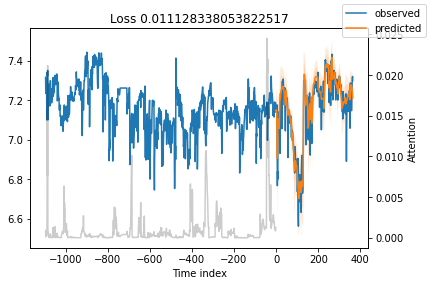

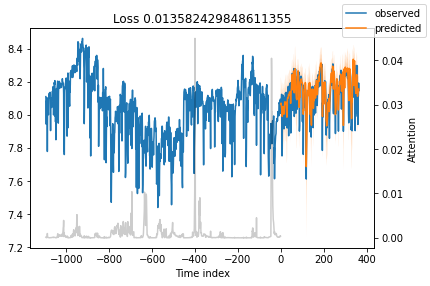

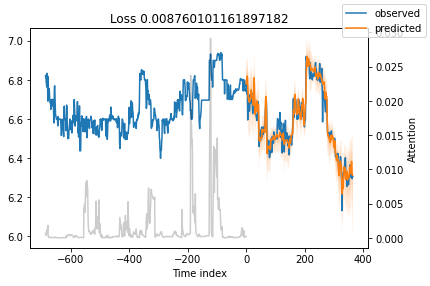

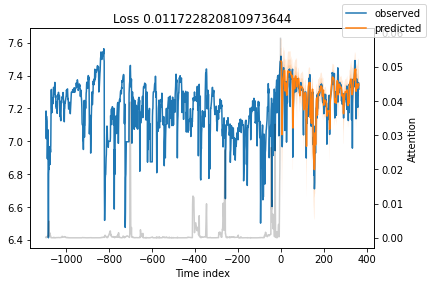

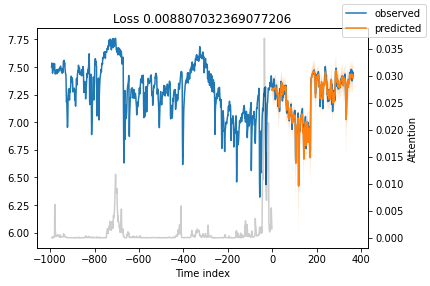

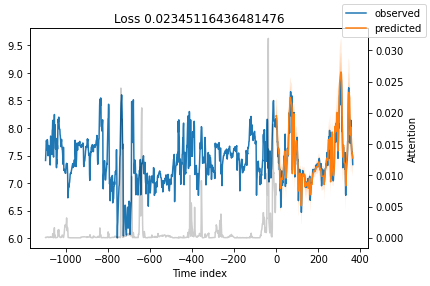

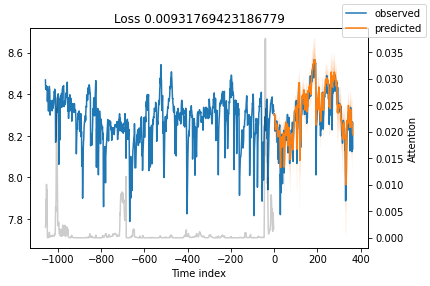

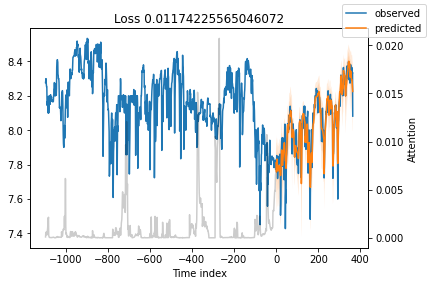

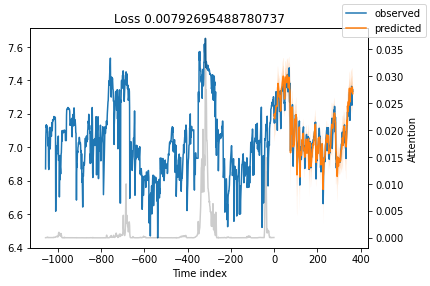

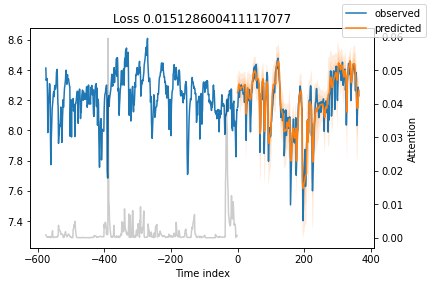

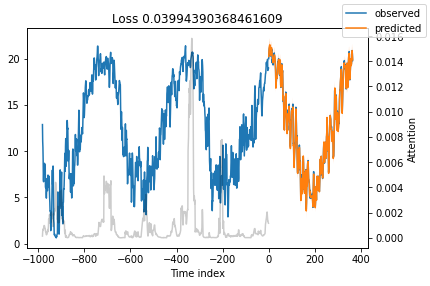

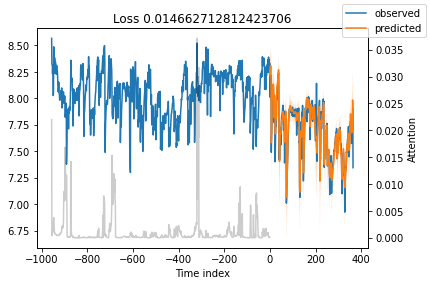

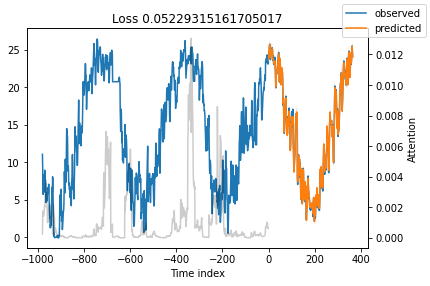

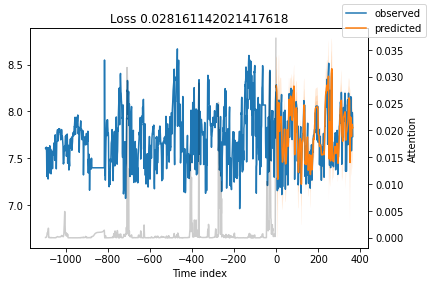

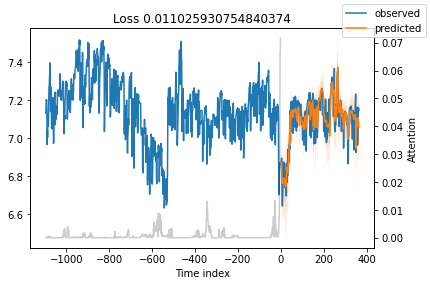

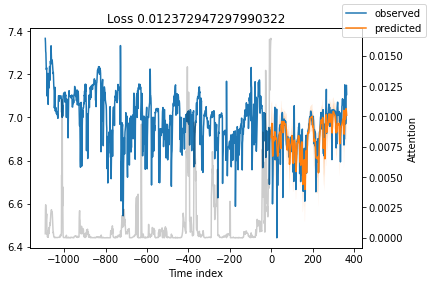

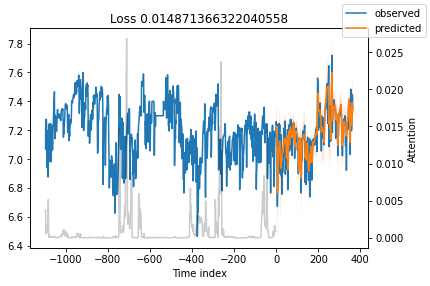

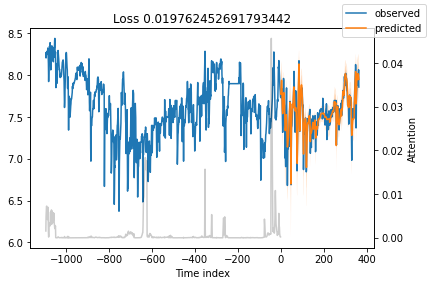

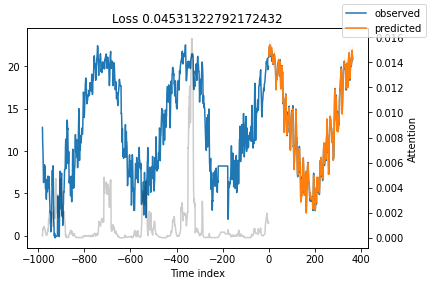

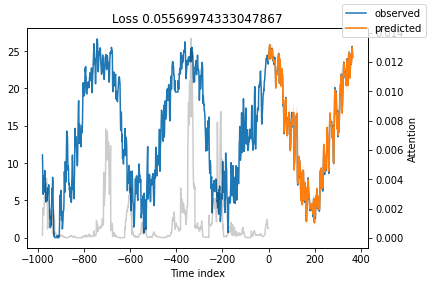

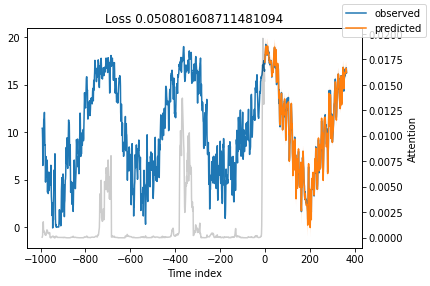

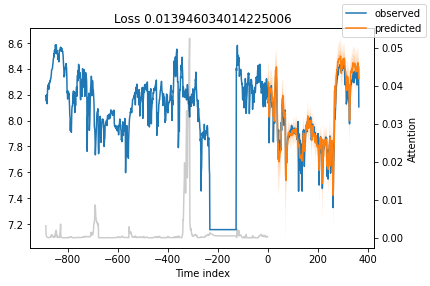

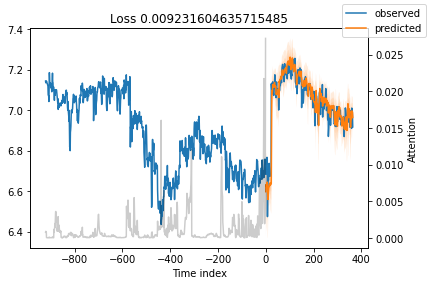

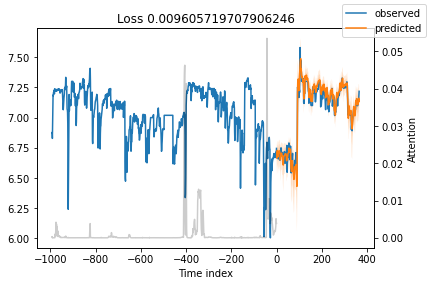

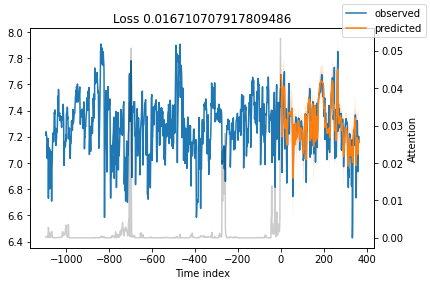

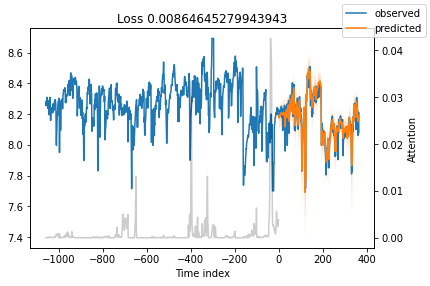

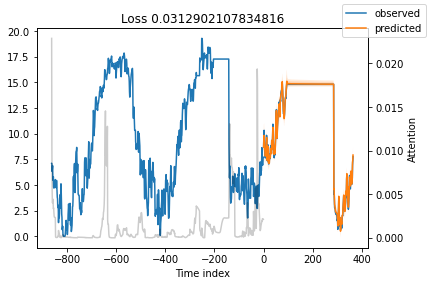

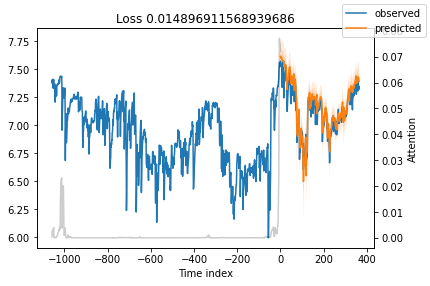

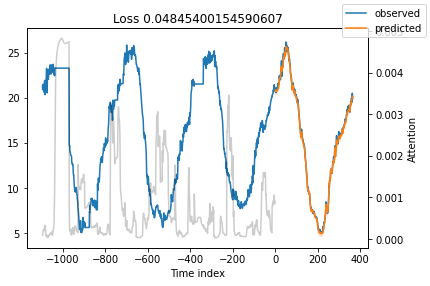

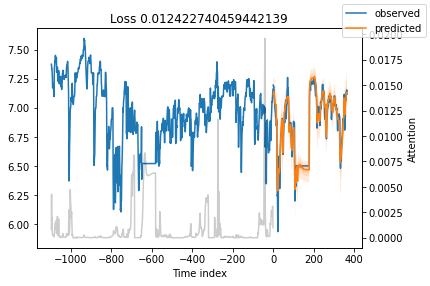

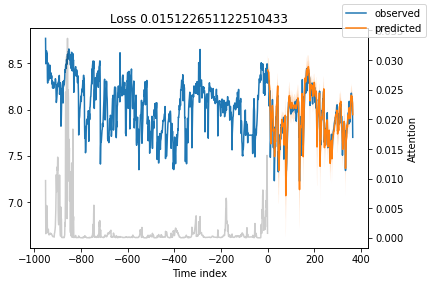

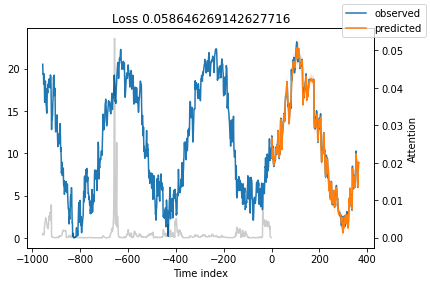

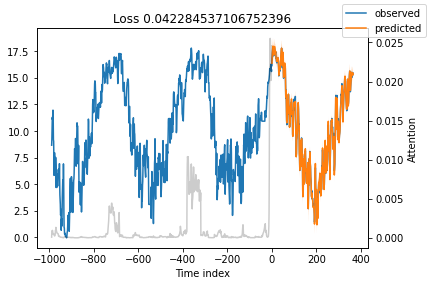

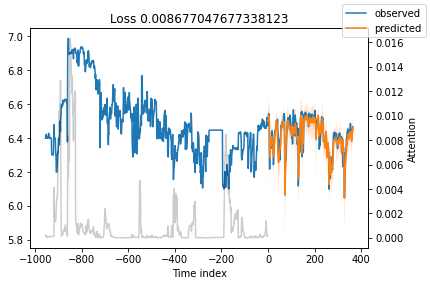

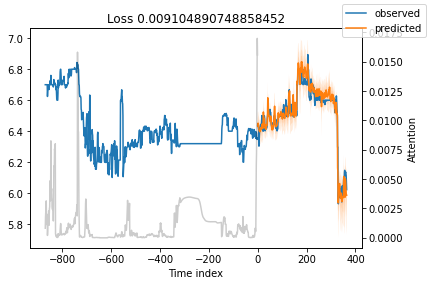

In [20]:
raw_predictions, x = tft.predict(val_dataloader, mode="raw", return_x=True)
for idx in range(35):
    tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

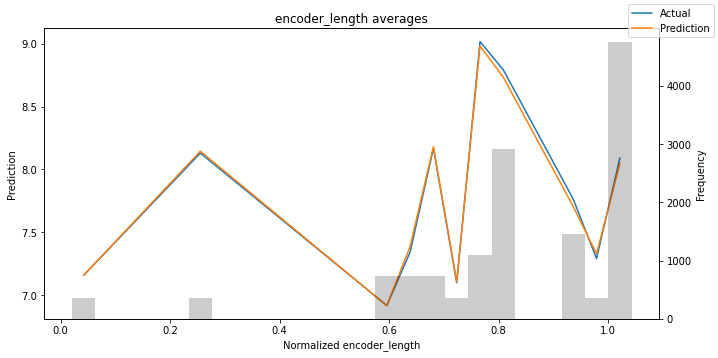

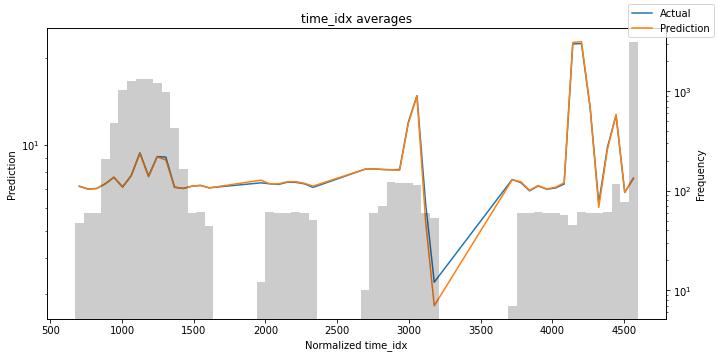

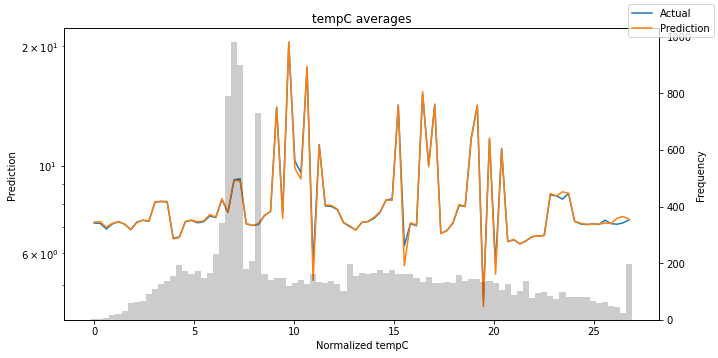

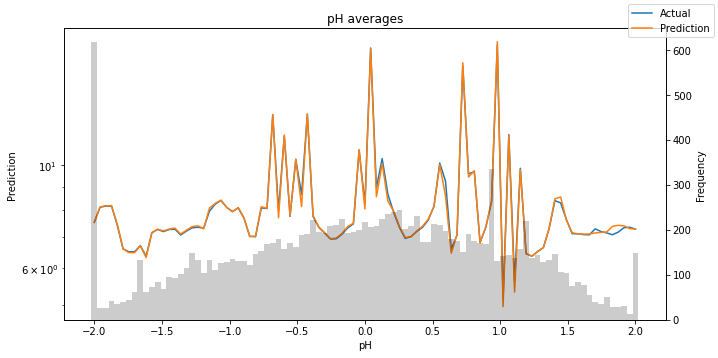

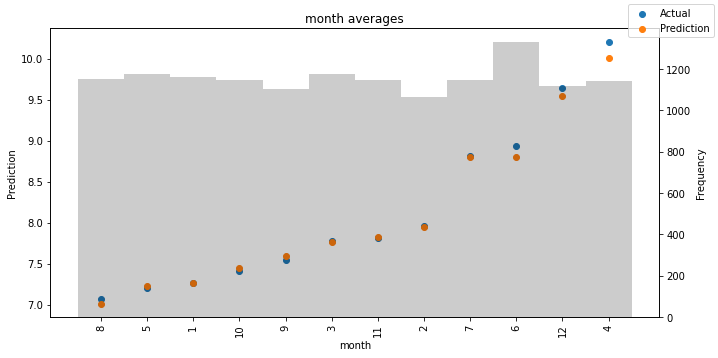

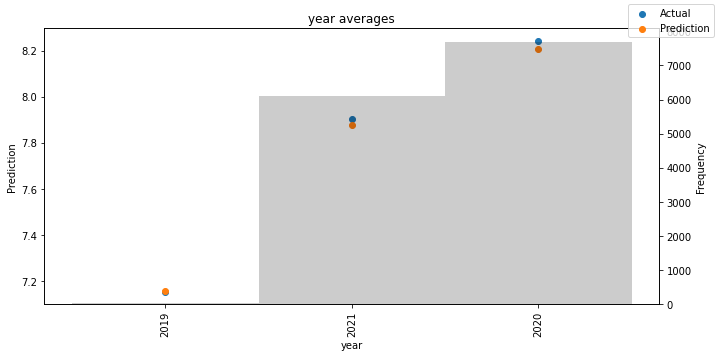

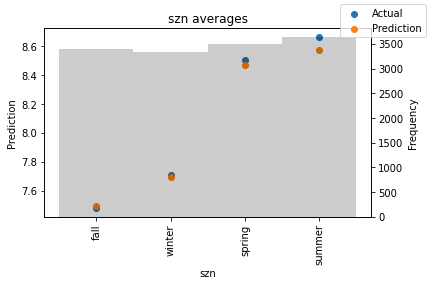

In [ ]:
predictions, x = tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = tft.calculate_prediction_actual_by_variable(x, predictions)
tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

In [21]:
encoder_data = data[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

last_data = data[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
    [last_data.assign(date=lambda x: x.date + pd.offsets.MonthBegin(i)) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)

decoder_data["time_idx"] += encoder_data["time_idx"].max() + 1 - decoder_data["time_idx"].min()

decoder_data["month"] = decoder_data.date.dt.month.astype(str).astype("category")

new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)


/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/data/timeseries.py:1244: UserWarning:

Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 2 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__group_ids': 9}, {'__group_id__group_ids': 42}]



IndexError: ignored

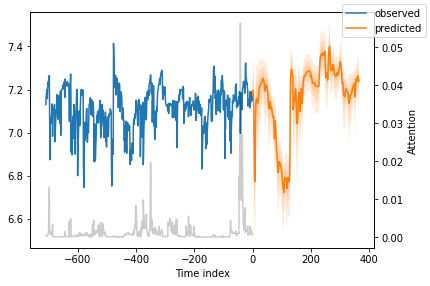

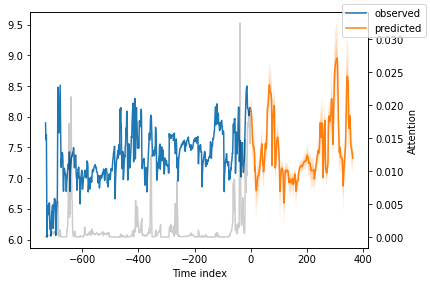

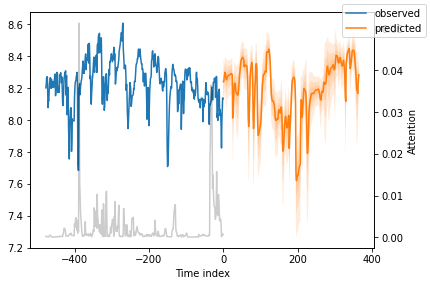

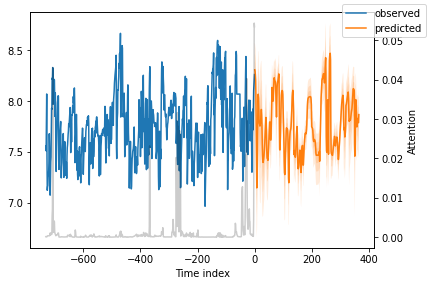

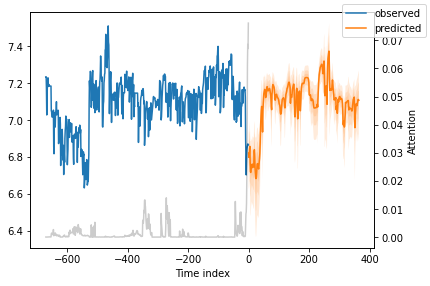

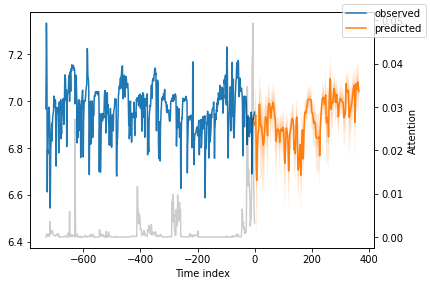

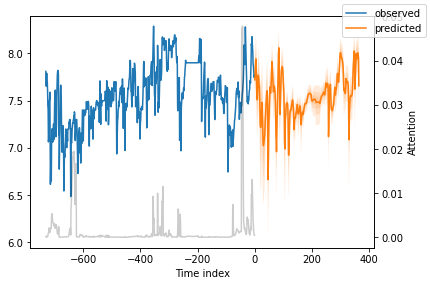

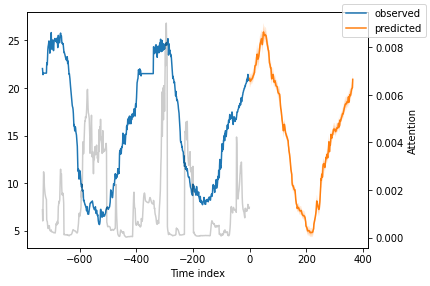

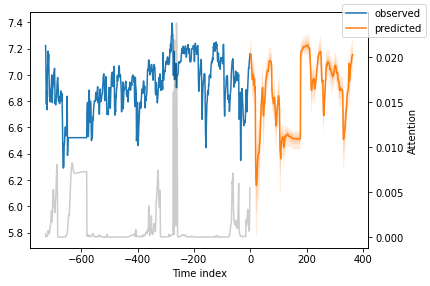

In [22]:
new_raw_predictions, new_x = tft.predict(new_prediction_data, mode="raw", return_x=True)

for idx in range(40):
    tft.plot_prediction(new_x, new_raw_predictions, idx=idx, show_future_observed=False);